In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning

In [56]:
tracks_df = pd.read_csv('tracks.csv')
tracks_df.head()

,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,popularity,album_type,album_id,album_name,album_release_date
0,2025-03-04T23:34:01Z,6ZRxnIHvjN0qTVRwz3PLtO,Smells Blood,4L0gz16xuM1as1OgYzh1SR,Kensuke Ushio,109280,False,56,album,05xPgo0O1tujgg6eDzIfxV,DEVILMAN crybaby (Original Soundtrack),2018-01-10
1,2025-03-04T18:52:29Z,4rk94uEZLJftdhnjp4Hwsx,Conflict,1ldNdtZX38LAsOk0ciLvb2,F.O.O.L,187527,False,32,single,6z5absG3SjLYPN8AhVcO0e,Revenger,2020-04-06
2,2025-03-04T18:47:34Z,0Obvb0dyqdOPyjWJJKMniU,Window Shop,7fVp0A6oCMfiQJihMnY0SZ,KNOWER,175208,False,29,album,7o5y1ttfkpL6zf6P2uCYPQ,Louis Cole and Genevieve Artadi,2010-10-01
3,2025-03-04T18:01:50Z,4MqJUXLycUCczH67JE06TA,Selecta 40',7wXSDFysHTrrNetXFfvTsF,NØKK,229714,False,8,single,3g3pfrt11jiC09HSLZKLBK,Selecta 40',2024-05-17
4,2025-03-03T17:04:51Z,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,Short n' Sweet (Deluxe),2025-02-14


In [57]:
artists_df = pd.read_csv('artists.csv')
artists_df.head()

,id,artist_name,followers,genres,popularity
0,00CYRdkMnA0mwfy1VQPA7X,ellis,42857,future house,46
1,2f9PTWJfMMDTAFZcvHy1Z5,OVERWERK,143567,NaN,45
2,6UocZe4AprSYBvmn3J0oqY,Shiny Toy Guns,131298,electronic rock,42
3,3gk0OYeLFWYupGFRHqLSR7,Showtek,483101,hardstyle,62
4,5jdbH48Rcr1jvVSVG0osQK,DNVR,4687,bass house,26


Exploratory Data Analysis

In [ ]:
artists_df = pd.read_csv('artists.csv')

# Handle missing genres by updating with missing genres from artists_missing_genres.csv
# Identify missing genres
na_genres_df = artists_df[artists_df['genres'].isna()]
print(f'{len(na_genres_df)} genres missing')

# Update missing genres
missing_genres_df = pd.read_csv('artists_missing_genres.csv')
artists_merged_df = pd.merge(artists_df, missing_genres_df[['id', 'genres']], on='id', how='left')
artists_df['genres'] = artists_df['genres'].fillna(artists_merged_df['genres_y'])

# Clean genre strings
artists_df['genres'] = [g.lower().replace('-',' ') if not isinstance(g, float) else g for g in artists_df['genres']]
print(f'{len(artists_df[artists_df['genres'].isna()])} genres missing after update')

# # Identify artists with unique genres to check for inaccuracies
# genre_counts = artists_df['genres'].value_counts()
# unique_genres = artists_df[artists_df['genres'].isin(genre_counts[genre_counts == 1].index)]
# unique_genres.sort_values(by='genres')
# artists_df[artists_df['genres'].astype(str).str.contains('seen live', na=False)]

corrected_genres = {
    'Saweetie': 'hip hop',
    'Vana': 'pop metal',
    'FWLR': 'bass house',
    'gladde paling': 'memetechno',
    'ShogunF': 'electronic',
    'Garrett Williamson': 'video game music',
    'WHIPPED CREAM': 'edm',
    'Remi Wolf': 'indie pop',
    'Daisy Grenade': 'pop punk',
    'Reneé Rap': 'pop',
    'Wildermiss': 'indie',
    'Aziya': 'indie pop'

}

corrected_genres_df = pd.DataFrame.from_dict(corrected_genres, orient='index', columns=['genres'])
corrected_genres_df  = corrected_genres_df.reset_index(names='artist_name')
artists_merged_df_2 = artists_df.merge(corrected_genres_df, on='artist_name', how='left')
artists_merged_df_2['genres_y'] = artists_merged_df_2['genres_y'].fillna(artists_merged_df_2['genres_x'])
artists_df['genres'] = artists_merged_df_2['genres_y']

# # Handle remaining null values
artists_df['genres'] = artists_df['genres'].fillna('unknown')
artists_df.head()


101 genres missing
9 genres missing after update


,id,artist_name,followers,genres,popularity
0,00CYRdkMnA0mwfy1VQPA7X,ellis,42857,future house,46
1,2f9PTWJfMMDTAFZcvHy1Z5,OVERWERK,143567,electronic,45
2,6UocZe4AprSYBvmn3J0oqY,Shiny Toy Guns,131298,electronic rock,42
3,3gk0OYeLFWYupGFRHqLSR7,Showtek,483101,hardstyle,62
4,5jdbH48Rcr1jvVSVG0osQK,DNVR,4687,bass house,26


In [35]:
artists_df.loc[artists_df['genres'].str.contains(r'core', case=False, na=False),'labels'] = 'core'

artists_df['labels'].value_counts()

labels
core    39
Name: count, dtype: int64

In [36]:
artists_df.loc[artists_df['genres'].str.contains(r'hyper', case=False, na=False)]

,id,artist_name,followers,genres,popularity,labels
23,2BOw2Ooy4maMEzNg1LR0HJ,marshall4,5157,hyperpop,30,NaN
24,7pI4Zmuib20gknwwWNqPpJ,gingus,6931,hyperpop,29,NaN
35,4QM5QCHicznALtX885CnZC,Slayyyter,423128,hyperpop,54,NaN
50,1AHswQqsDNmu1xaE8KpBne,COBRAH,194817,hyperpop,55,NaN
57,5lvB2ZiSrNidq4GaFrWHK2,bugcried,20880,hyperpop,42,NaN
66,0nZHjqvdLoBy50ZzUH5FNU,Cecile Believe,42465,hyperpop,40,NaN
80,41pq9H8tWm2Rf4bQZobhNh,User-177606669,12185,hyperpop,34,NaN
102,5xmw3tD4MbvhA1ay1U0HEC,COUCOU CHLOE,92607,hyperpop,42,NaN
139,10zsHcOcO047KmhOhi57iL,xaev,10365,hyperpop,33,NaN
174,3M3wTTCDwicRubwMyHyEDy,Shygirl,319785,hyperpop,62,NaN


In [37]:
# Convert added at into date, time, and day of week
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at']).dt.tz_convert('US/Pacific')
tracks_df['added_at_date'] = tracks_df['added_at'].dt.date
tracks_df['added_at_month'] = tracks_df['added_at'].dt.to_period('M')
tracks_df['added_at_time'] = tracks_df['added_at'].dt.hour
tracks_df['added_at_dow_val'] = tracks_df['added_at'].dt.dayofweek.values
tracks_df['added_at_dow_name'] = tracks_df['added_at'].dt.day_name()

# Convert release date into date
tracks_df['album_release_date'] = pd.to_datetime(tracks_df['album_release_date'], format='mixed', utc=True)
tracks_df['release_year'] = tracks_df['album_release_date'].dt.year
tracks_df['release_add_delta'] = round((tracks_df['added_at'] - tracks_df['album_release_date']).astype(np.int64) / (60 * 60 * 24 * 10**9)) # Days
# merge
artists_df= artists_df.rename(columns={'id': 'artist_id'})
merged_df = pd.merge(tracks_df, artists_df, on='artist_id')

# Clean dupicate columns
merged_df = merged_df.rename(columns={'popularity_x': 'track_popularity', 'popularity_y': 'artist_popularity', 'followers': 'artist_followers', 'artist_name_x':'artist_name'})
merged_df.drop(columns='artist_name_y', inplace=True)
merged_df.head()



C:\Users\ledge\AppData\Local\Temp\ipykernel_12752\1743058604.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tracks_df['added_at_month'] = tracks_df['added_at'].dt.to_period('M')


,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,track_popularity,album_type,album_id,...,added_at_month,added_at_time,added_at_dow_val,added_at_dow_name,release_year,release_add_delta,artist_followers,genres,artist_popularity,labels
0,2025-03-04 15:34:01-08:00,6ZRxnIHvjN0qTVRwz3PLtO,Smells Blood,4L0gz16xuM1as1OgYzh1SR,Kensuke Ushio,109280,False,56,album,05xPgo0O1tujgg6eDzIfxV,...,2025-03,15,1,Tuesday,2018,2611.0,138638,anime,57,NaN
1,2025-03-04 10:52:29-08:00,4rk94uEZLJftdhnjp4Hwsx,Conflict,1ldNdtZX38LAsOk0ciLvb2,F.O.O.L,187527,False,32,single,6z5absG3SjLYPN8AhVcO0e,...,2025-03,10,1,Tuesday,2020,1794.0,88300,synthwave,46,NaN
2,2025-03-04 10:47:34-08:00,0Obvb0dyqdOPyjWJJKMniU,Window Shop,7fVp0A6oCMfiQJihMnY0SZ,KNOWER,175208,False,29,album,7o5y1ttfkpL6zf6P2uCYPQ,...,2025-03,10,1,Tuesday,2010,5269.0,141041,experimental,41,NaN
3,2025-03-04 10:01:50-08:00,4MqJUXLycUCczH67JE06TA,Selecta 40',7wXSDFysHTrrNetXFfvTsF,NØKK,229714,False,8,single,3g3pfrt11jiC09HSLZKLBK,...,2025-03,10,1,Tuesday,2024,292.0,247,uk garage,7,NaN
4,2025-03-03 09:04:51-08:00,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,...,2025-03,9,0,Monday,2025,18.0,20013528,pop,91,NaN


<Axes: xlabel='added_at', ylabel='release_add_delta'>

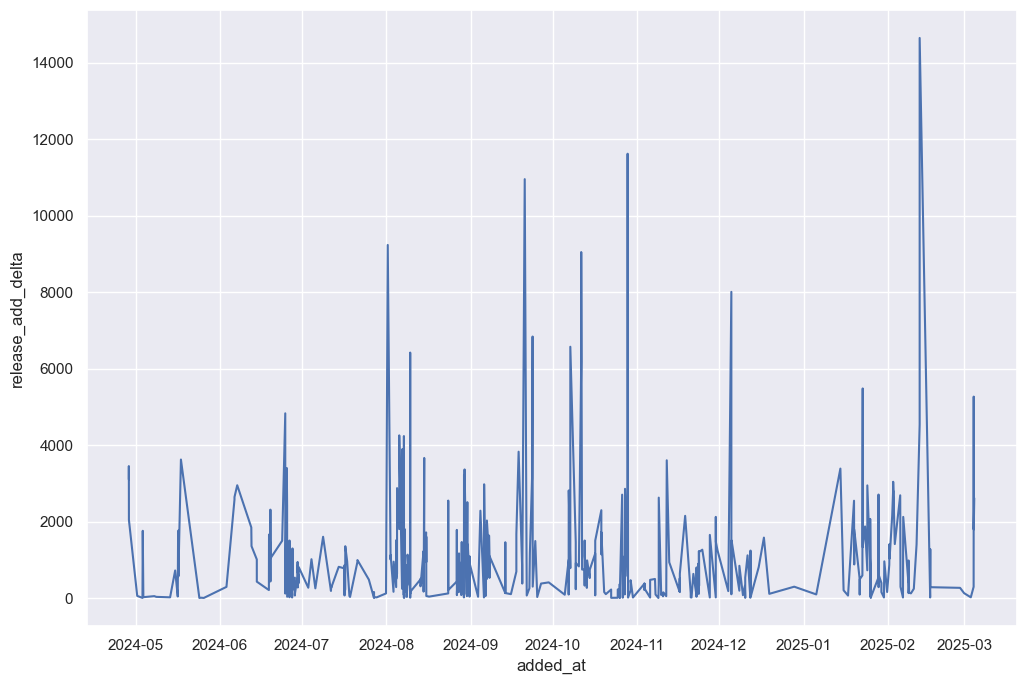

In [38]:
sns.lineplot(data=tracks_df, x='added_at', y='release_add_delta')

<Axes: xlabel='release_add_delta', ylabel='Count'>

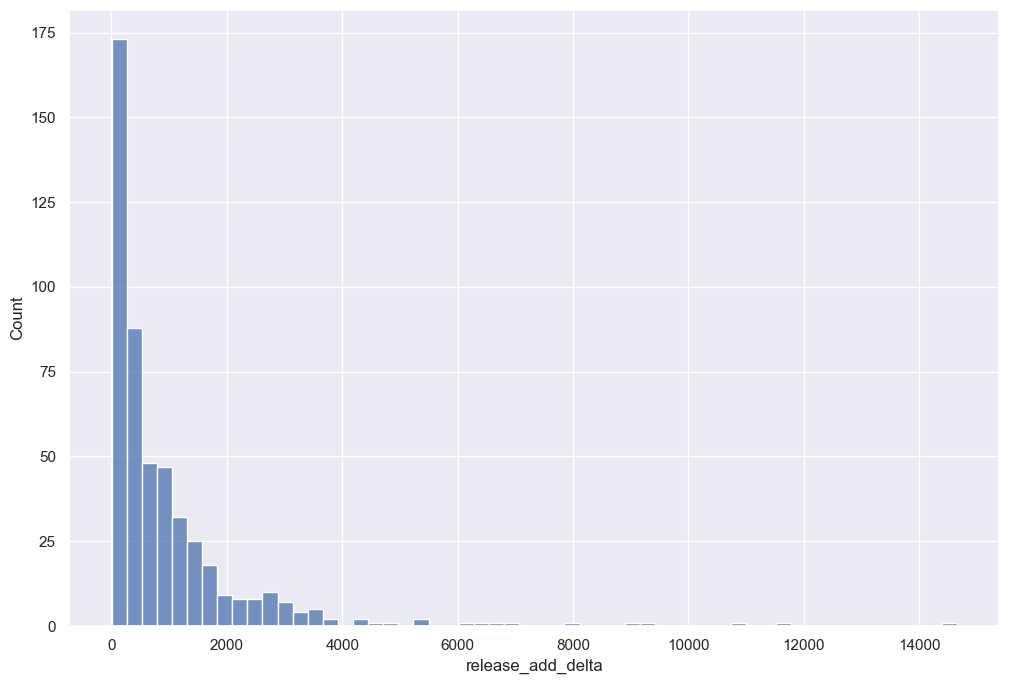

In [39]:
sns.histplot(tracks_df['release_add_delta'])
# tracks_df[tracks_df['artist_id'] == '6MF58APd3YV72Ln2eVg710']

In [40]:
weekly_saves_df = merged_df.groupby(['added_at_dow_val']).aggregate({'track_id': 'count', 'added_at_dow_name': 'first' }).sort_values(by='track_id', ascending=False).reset_index()
weekly_saves_df

,added_at_dow_val,track_id,added_at_dow_name
0,2,100,Wednesday
1,4,81,Friday
2,3,79,Thursday
3,5,69,Saturday
4,6,67,Sunday
5,1,66,Tuesday
6,0,38,Monday


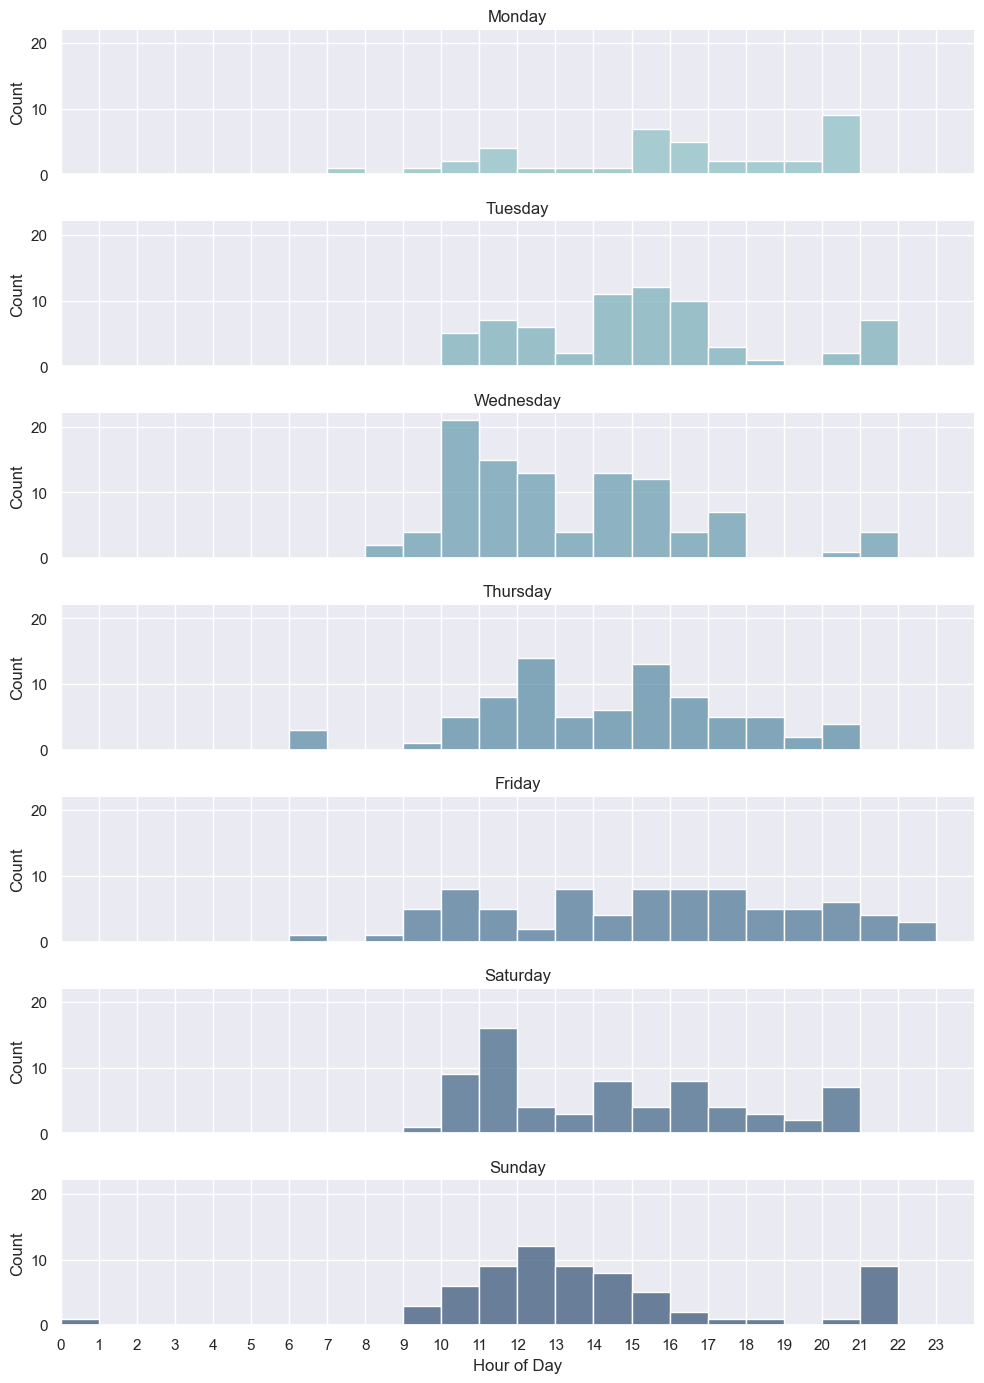

In [41]:

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tracks_df.sort_values(by='added_at_dow_val'), row="added_at_dow_name", hue="added_at_dow_val", aspect=5, height=2, palette=pal)
g.set_titles("{row_name}")
tracks_df
g.map(sns.histplot, "added_at_time", binwidth=1)
max_freq = max([ax.get_ylim()[1] for ax in g.axes.flat]) 
g.set(xlim=(0, 24), ylim=(0, max_freq))
plt.xticks(np.arange(0, 24, 1))
g.set_xlabels('Hour of Day')
# g.map(sns.kdeplot, "popularity", clip_on=False, color="w", lw=2, bw_adjust=.5)

# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


<Axes: xlabel='release_year', ylabel='Count'>

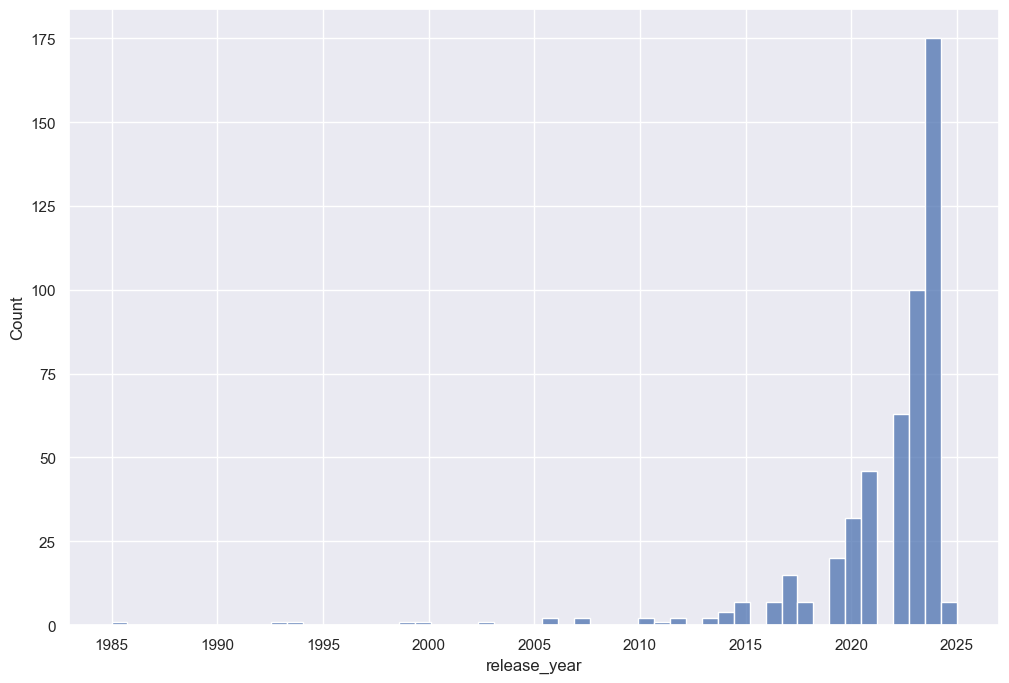

In [42]:
sns.histplot(merged_df['release_year'])

<Axes: xlabel='release_year', ylabel='popularity'>

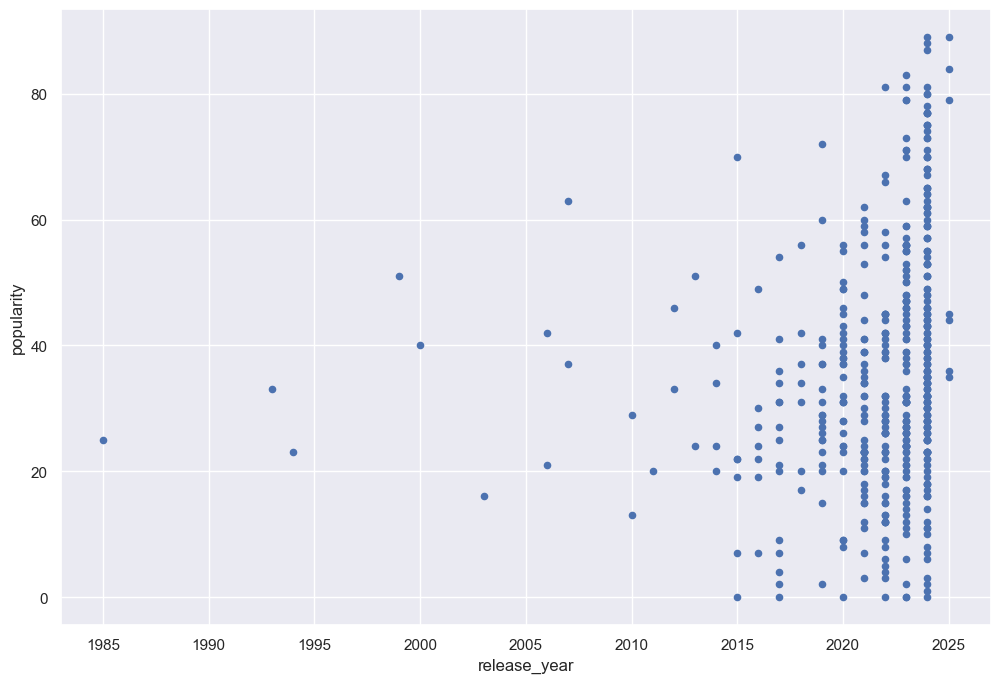

In [43]:
tracks_df.plot(y='popularity', x='release_year',kind='scatter')

In [44]:
value_counts = merged_df['genres'].value_counts()
# filtered_genres = artists_df[artists_df['genres'].isin(value_counts[value_counts > 2].index)]
top_genres = value_counts[value_counts >=10]
top_genres.sum()
# sns.barplot(value_counts[value_counts > 2])
# plt.xticks(rotation=45)

np.int64(327)

<Axes: xlabel='total_bill', ylabel='Density'>

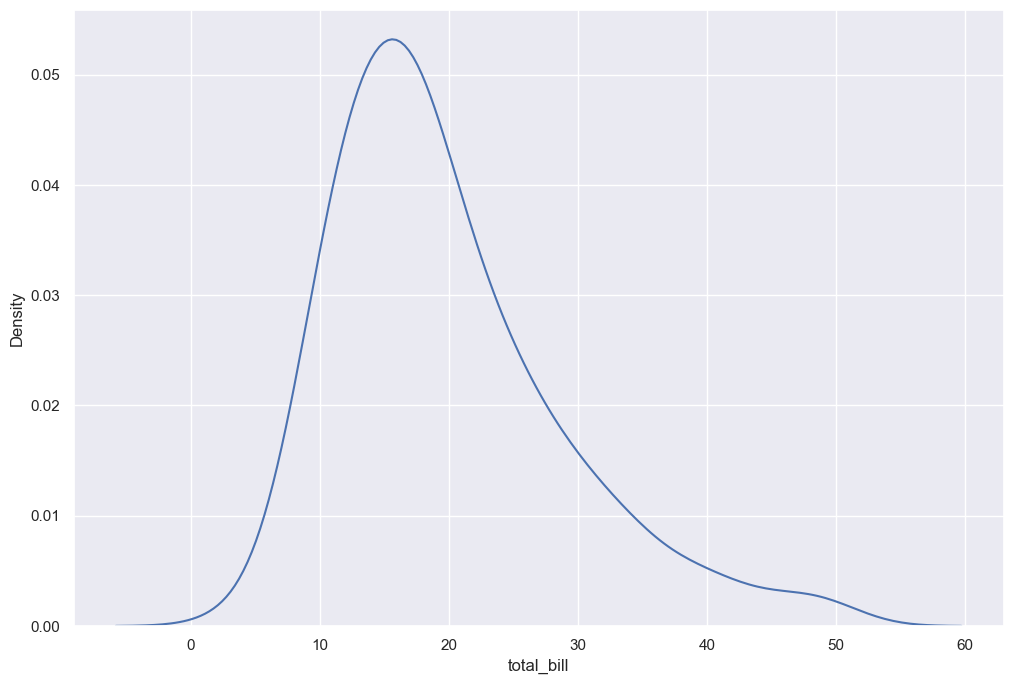

In [45]:
tips = sns.load_dataset("tips")
sns.kdeplot(data=tips, x="total_bill")

In [46]:
top_songs_by_genre = merged_df[merged_df['genres'].isin(top_genres.index)]
song_genre_counts = top_songs_by_genre['genres'].value_counts()
song_genre_counts
top_songs_by_genre = top_songs_by_genre.sort_values(by='genres', key=lambda x: x.map(song_genre_counts), ascending=False)
top_songs_by_genre.head()

,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,track_popularity,album_type,album_id,...,added_at_month,added_at_time,added_at_dow_val,added_at_dow_name,release_year,release_add_delta,artist_followers,genres,artist_popularity,labels
426,2024-06-27 11:46:21-07:00,6ul4s7dwLMYtGOkyIfMWEW,DROP EM,2K9qsrYnsu1EWt7ZQkkuXb,Ray Volpe,238153,False,36,single,3KspUuYZY7CFg2BF72Tt03,...,2024-06,11,3,Thursday,2023,308.0,151201,dubstep,51,NaN
421,2024-06-28 10:11:39-07:00,4DVkTvbzmQKB31PciE7X2a,Laserbeam - ÆON:MODE Remix,2K9qsrYnsu1EWt7ZQkkuXb,Ray Volpe,164651,False,43,single,1kv1HLsS2E7NdJekRZI5am,...,2024-06,10,4,Friday,2023,533.0,151201,dubstep,51,NaN
422,2024-06-27 15:32:18-07:00,02GasgQz5JPjP2slW8dwrx,ASCENSION,2K9qsrYnsu1EWt7ZQkkuXb,Ray Volpe,160000,False,32,single,3KspUuYZY7CFg2BF72Tt03,...,2024-06,15,3,Thursday,2023,308.0,151201,dubstep,51,NaN
34,2025-02-03 11:50:38-08:00,6zBFQ5dWHEmEx2RDoZ1ZP2,Dominate,37PZXblQTqpEWGdjctNcGP,Space Laces,234375,False,39,single,3Ger0zMysHrdm6H15k1n3D,...,2025-02,11,0,Monday,2021,1411.0,107797,dubstep,47,NaN
44,2025-01-30 15:38:46-08:00,2kO0AAHz7hYN6taN6oUMwT,Arabian Knights,0qPGd8tOMHlFZt8EA1uLFY,RIOT,186400,False,18,single,1PicnlQtu8oliMzWJcQcZV,...,2025-01,15,3,Thursday,2022,959.0,91798,dubstep,48,NaN


KeyboardInterrupt: 

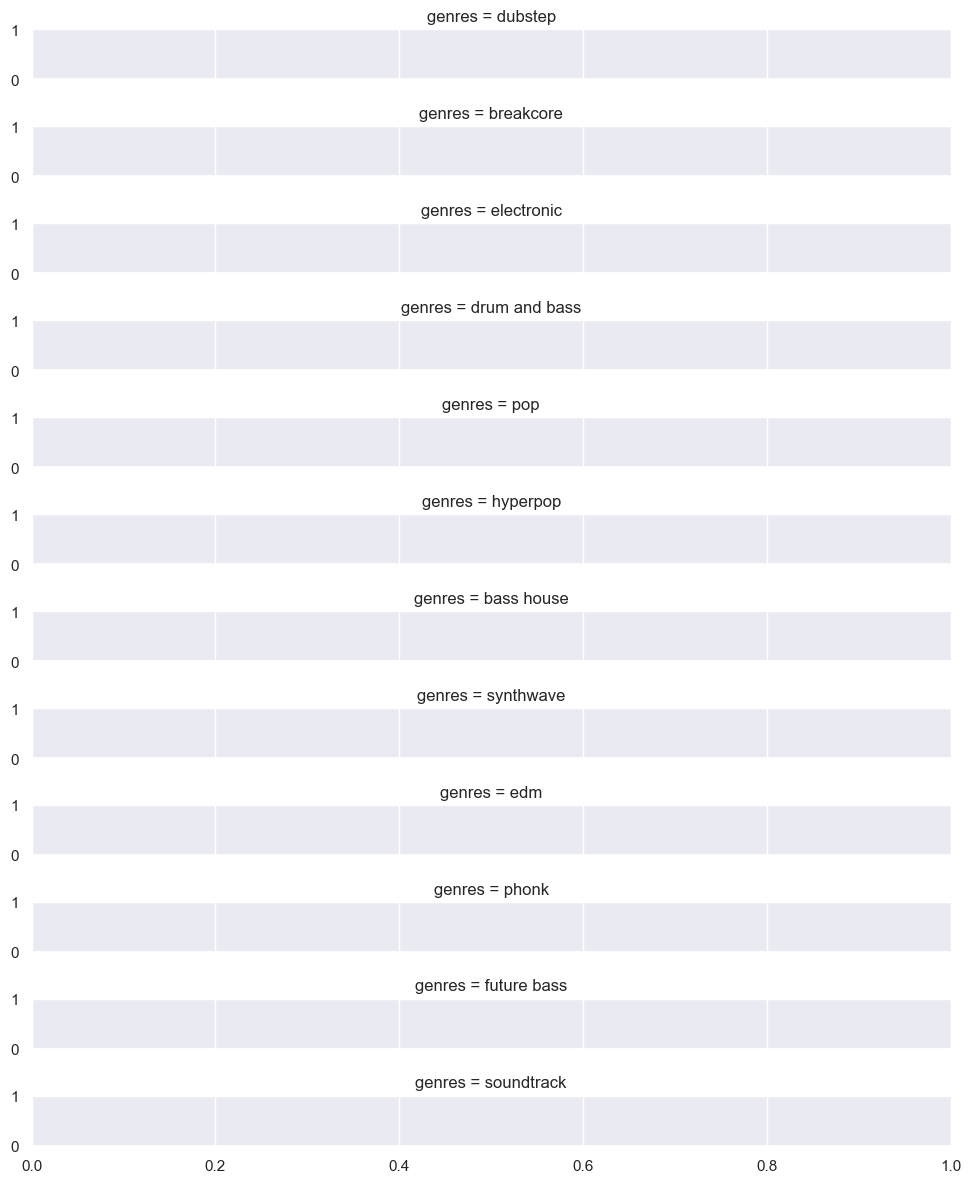

In [47]:

# top_songs_by_genre['added_at_unix'] = top_songs_by_genre['added_at'].astype(np.int64) / 10**18
g = sns.FacetGrid(top_songs_by_genre, row="genres", hue="genres", aspect=10, height=1, palette=pal)
# tracks_df
g.map(sns.kdeplot, "added_at_time",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=.5)

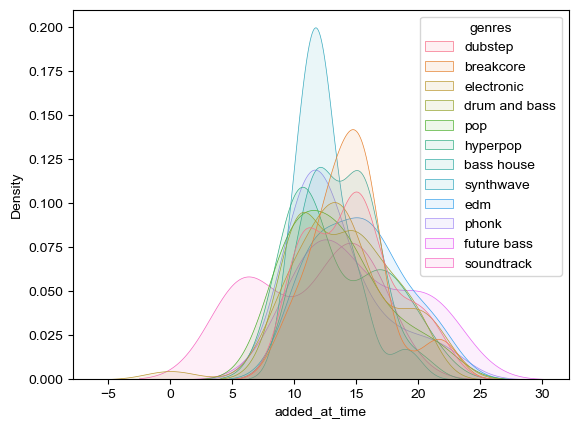

In [ ]:
sns.kdeplot(data=top_songs_by_genre, x="added_at_time", hue="genres", common_norm=False, fill=True, alpha=.1, linewidth=.5)
sns.set_theme(rc={'figure.figsize':(12,8)})

([<matplotlib.axis.XTick at 0x268fce39d10>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24')])

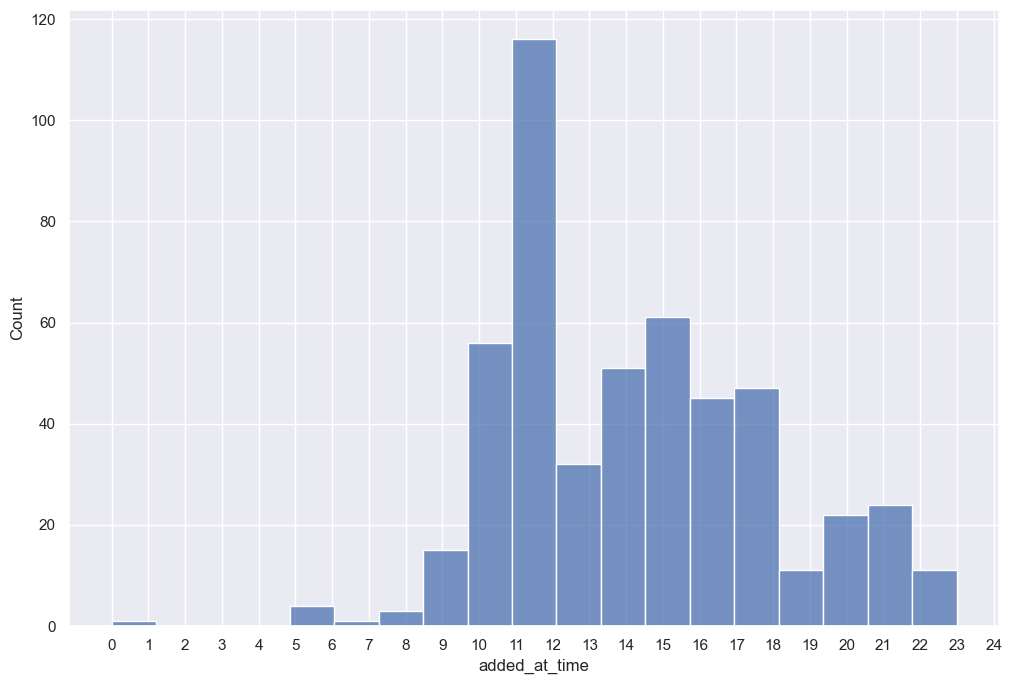

In [ ]:
fig = sns.histplot(data=merged_df, x="added_at_time")
# plt.yticks(fig.get_yticks(), fig.get_yticks() * 100)
# plt.ylabel('Distribution [%]', fontsize=16)
plt.xticks(range(0,25))

In [ ]:
artist_counts = tracks_df['artist_name'].value_counts()
artist_counts.head()

artist_name
Virtual Riot     17
REAPER           12
Charli xcx        9
Rezz              8
Chappell Roan     7
Name: count, dtype: int64

<Axes: xlabel='popularity', ylabel='Count'>

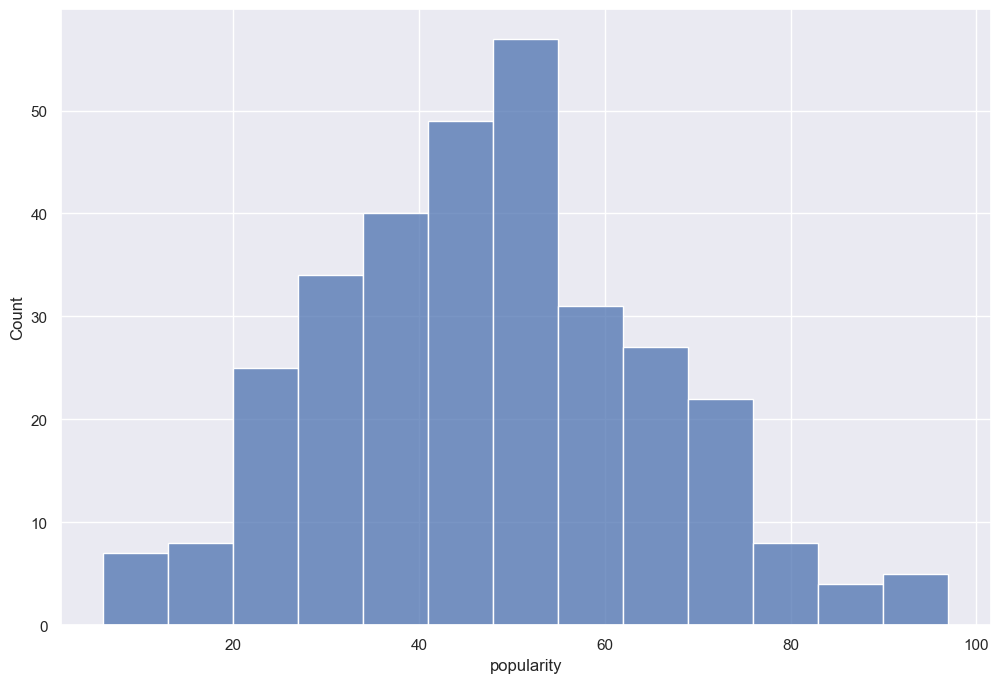

In [ ]:
sns.histplot(artists_df['popularity'])

<Axes: xlabel='popularity', ylabel='Count'>

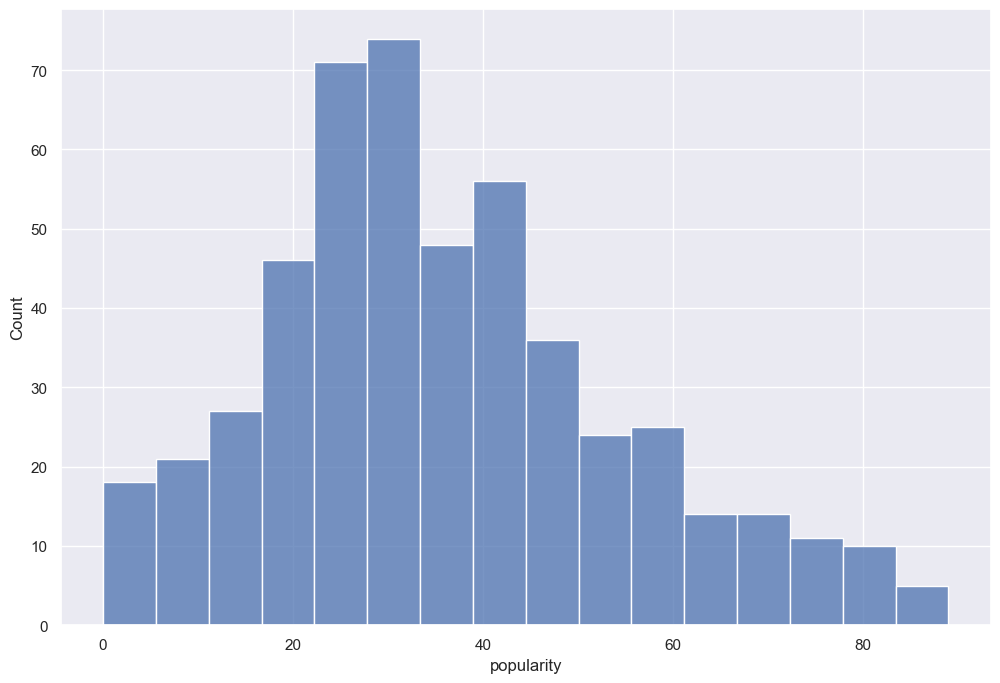

In [ ]:
sns.histplot(tracks_df['popularity'])

In [ ]:
# sns.histplot(merged_df['added_at_date'])

saves_by_date = merged_df.groupby(['added_at_date']).agg({'track_id': 'count', 'added_at_dow': 'first'})
saves_by_date.rename(columns={'track_id':'tracks_saved'}, inplace=True)
saves_by_date = saves_by_date.reset_index()
# saves_by_date.describe()
saves_by_date = saves_by_date.sort_values(by='added_at_date')
start_date =saves_by_date.head(1)
end_date =saves_by_date.tail(1)
full_date_range = pd.DataFrame()
saves_by_date['added_at_date'] = pd.to_datetime(saves_by_date['added_at_date'], utc=True)
full_date_range['added_at_date'] = pd.date_range(start=start_date['added_at_date'][0],end=end_date['added_at_date'][154])
full_date_range['added_at_date'] = pd.to_datetime(full_date_range['added_at_date'], utc=True)

full_date_range = full_date_range.merge(saves_by_date, on='added_at_date', how='left')
# saves_by_date
full_date_range['tracks_saved'] = full_date_range['tracks_saved'].fillna(0)
# full_date_range


full_date_range['added_at_week'] = full_date_range['added_at_date'].dt.isocalendar().week
full_date_range['added_at_week_date'] = full_date_range['added_at_date'] - pd.to_timedelta(full_date_range['added_at_date'].dt.weekday, unit='D')

sns.lineplot(data=full_date_range,x='added_at_week_date', y='tracks_saved')
plt.xticks(rotation=45)
# sns.histplot(full_date_range['tracks_saved'])

KeyError: "Column(s) ['added_at_dow'] do not exist"

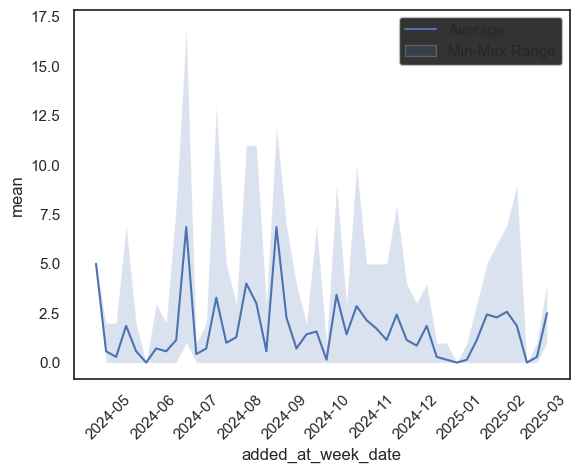

In [ ]:
agg_data = full_date_range.groupby('added_at_week_date')['tracks_saved'].agg(['min', 'max', 'mean']).reset_index()
# Plot the mean line
sns.lineplot(data=agg_data, x='added_at_week_date', y='mean', label='Average')

# Add min and max as a shaded area
plt.fill_between(agg_data['added_at_week_date'], agg_data['min'], agg_data['max'], alpha=0.2, label='Min-Max Range')

plt.xticks(rotation=45)
plt.legend()
plt.show()

C:\Users\ledge\AppData\Local\Temp\ipykernel_1496\3887447213.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  full_date_range['added_at_month'] = full_date_range['added_at_date'].dt.to_period('M')
C:\Users\ledge\AppData\Local\Temp\ipykernel_1496\3887447213.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


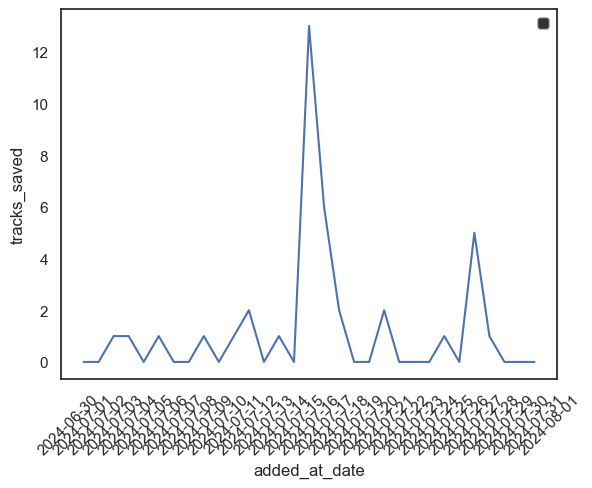

In [ ]:
import matplotlib.dates as mdates
full_date_range['added_at_month'] = full_date_range['added_at_date'].dt.to_period('M')
july = full_date_range[full_date_range['added_at_month'] == '2024-07']

agg_data_july = july.groupby('added_at_week_date')['tracks_saved'].agg(['min', 'max', 'mean']).reset_index()

# Plot the mean line
# sns.lineplot(data=agg_data_july, x='added_at_week_date', y='mean', label='Average')
sns.lineplot(data=july, x='added_at_date', y='tracks_saved')
# Add min and max as a shaded area
# plt.fill_between(agg_data_july['added_at_week_date'], agg_data_july['min'], agg_data_july['max'], alpha=0.2, label='Min-Max Range')

plt.xticks(rotation=45)
# Set x-axis to show every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD
plt.legend()
plt.show()

In [ ]:
# Want best time slots to advertise new pop music
# Look at genre over saved date/time
# 

# User stories, Jacq vs Merc vs Luis, can we be categorized into different "types" of users
# What characteristics define those users?
# New music seeker vs Merc songs of the week

# What kind of spotify user am I?

<Axes: xlabel='added_at_date', ylabel='track_id'>

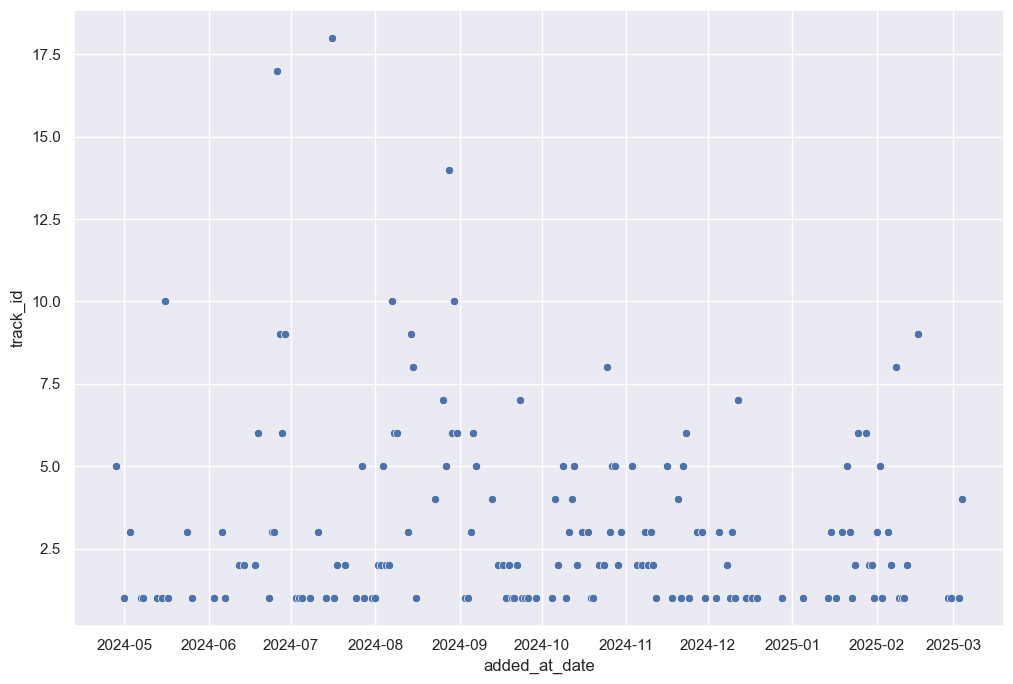

In [ ]:
# sns.histplot(merged_df['added_at_date'])
summary_df = merged_df.groupby(['added_at_date']).agg({'track_id': 'count'}).reset_index()
sns.scatterplot(summary_df, x='added_at_date', y='track_id')

In [ ]:
genres_by_date = top_songs_by_genre.groupby(['added_at_month', 'genres']).agg({'track_id': 'count'}).reset_index()
genres_by_date['added_at_month'] = genres_by_date['added_at_month'].dt.to_timestamp()
genres_by_date = genres_by_date.sort_values(by='added_at_month')
genres_by_date

,added_at_month,genres,track_id
0,2024-04-01,synthwave,5
1,2024-05-01,bass house,1
2,2024-05-01,breakcore,1
3,2024-05-01,drum and bass,1
4,2024-05-01,dubstep,1
...,...,...,...
87,2025-02-01,phonk,3
88,2025-02-01,pop,5
89,2025-02-01,synthwave,1
90,2025-03-01,pop,1


ConversionError: Failed to convert value(s) to axis units: 'added_at_month'

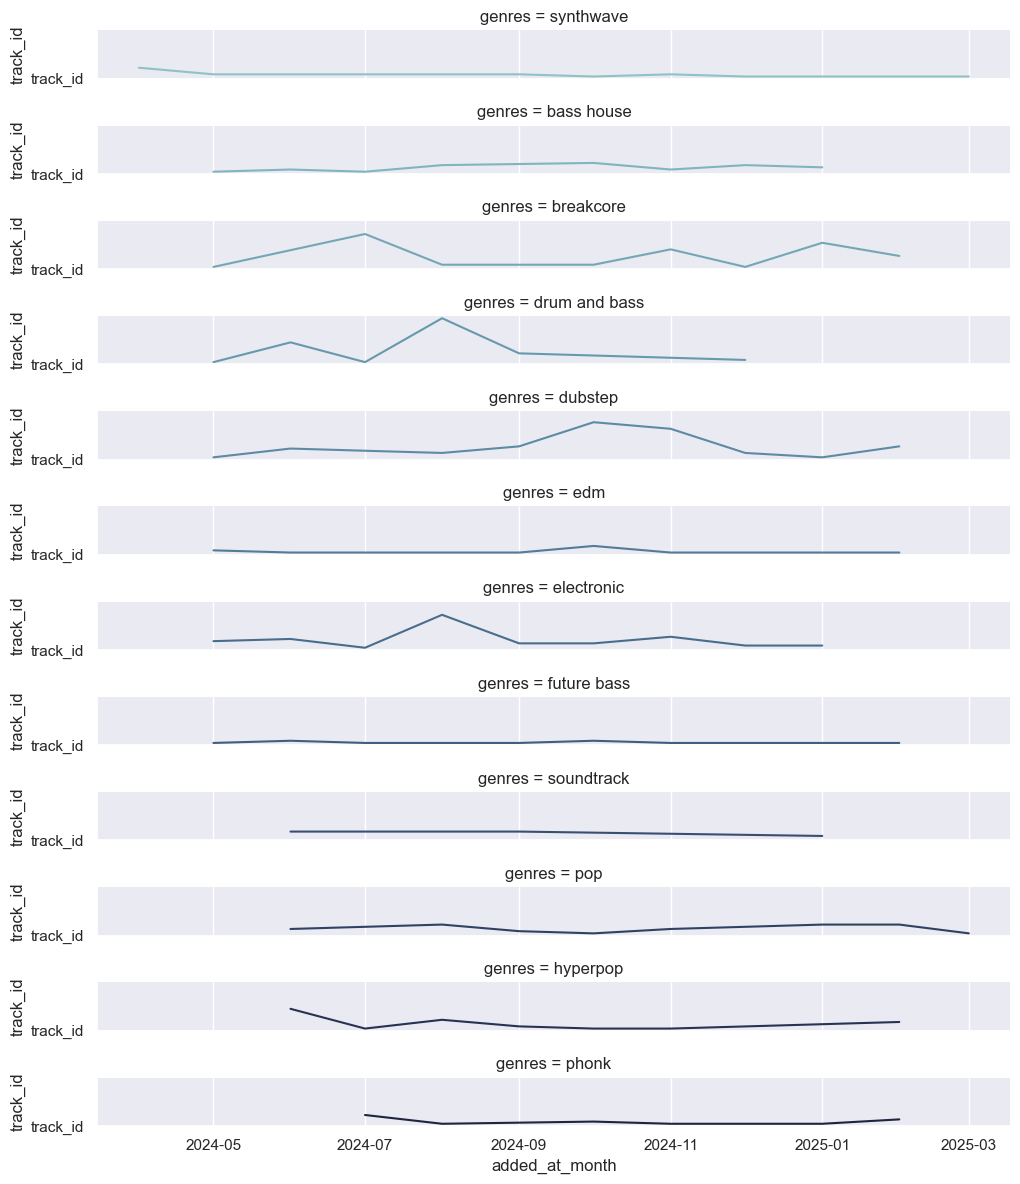

In [ ]:
y = sns.FacetGrid(genres_by_date, row="genres", hue="genres", aspect=10, height=1, palette=pal)
y.map(sns.lineplot, 'added_at_month', 'track_id')

# X = added at date, 
# release time - added at date
# How long between release and save date? How long does it take my listener to save new music after it's released?
# Populartiy by release year


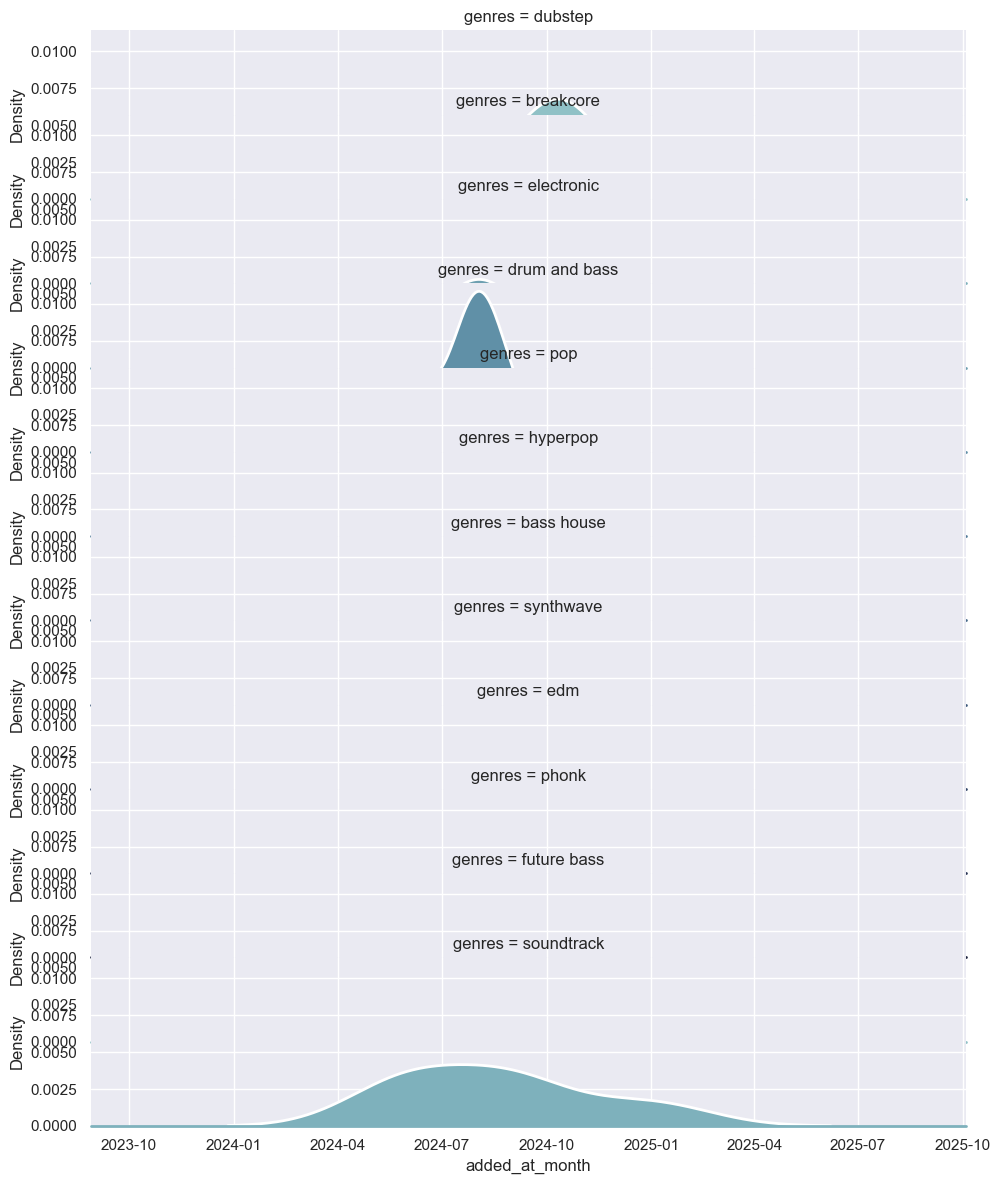

In [ ]:
# top_songs_by_genre['added_at_month'] = top_songs_by_genre['added_at_month'].dt.to_timestamp()
y = sns.FacetGrid(top_songs_by_genre, row="genres", hue="genres", aspect=10, height=1, palette=pal)

y.map(sns.kdeplot, 'added_at_month', fill=True, alpha=1, linewidth=.5)
y.map(sns.kdeplot, "added_at_month", clip_on=False, color="w", lw=2)

# passing color=None to refline() uses the hue mapping
y.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
y.figure.subplots_adjust(hspace=-.5)

# y.set_titles("")
# y.set(yticks=[], ylabel="")
y.despine(bottom=True, left=True)


What length of songs am I most frequently saving?

How many followers do the artists I have saved usually have?

Which day of the week am I saving the most songs?

Which time slot of the week am I saving the most songs?

Is there statistical significance between day of the week and added at time?

What time frame after song release am I most frequently saving songs?

Is there a correlation between the day of the week that a song was released and the time taken before saving it?

Is there a correlation between the artist's followers/popularity and the time it takes before I save the song?

What's my top genre?

What patterns of genre saving are there over time? 